# Preprocessing

In [53]:
import os

DATASET_NAME = "drsprg"
BASE_DIR = f"../data/processed/{DATASET_NAME}/"
IMAGES_DIR = os.path.join(BASE_DIR, "jpgs/")
DATASET = os.path.join(BASE_DIR, "data_list_export_120217.xlsx")

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Preprocess data set

In [55]:
df = pd.read_excel(DATASET, index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 107 entries, 1 to 107
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   study_name  107 non-null    object
 1   gender      107 non-null    object
 2   age         107 non-null    int64 
 3   ckd         107 non-null    int64 
 4   lk          107 non-null    int64 
 5   scr         107 non-null    int64 
 6   crc         107 non-null    int64 
 7   mag3        107 non-null    int64 
 8   edta        107 non-null    int64 
 9   flood       107 non-null    int64 
dtypes: int64(8), object(2)
memory usage: 9.2+ KB


In [56]:
df["ckd"].unique()

array([1, 3, 2, 4, 5])

In [57]:
class_0_stages = [1, 2]
class_1_stages = [3, 4, 5]

In [58]:
df["label"] = df["ckd"].apply(lambda x: 0 if x in class_0_stages else 1)
df["label"].unique()

array([0, 1])

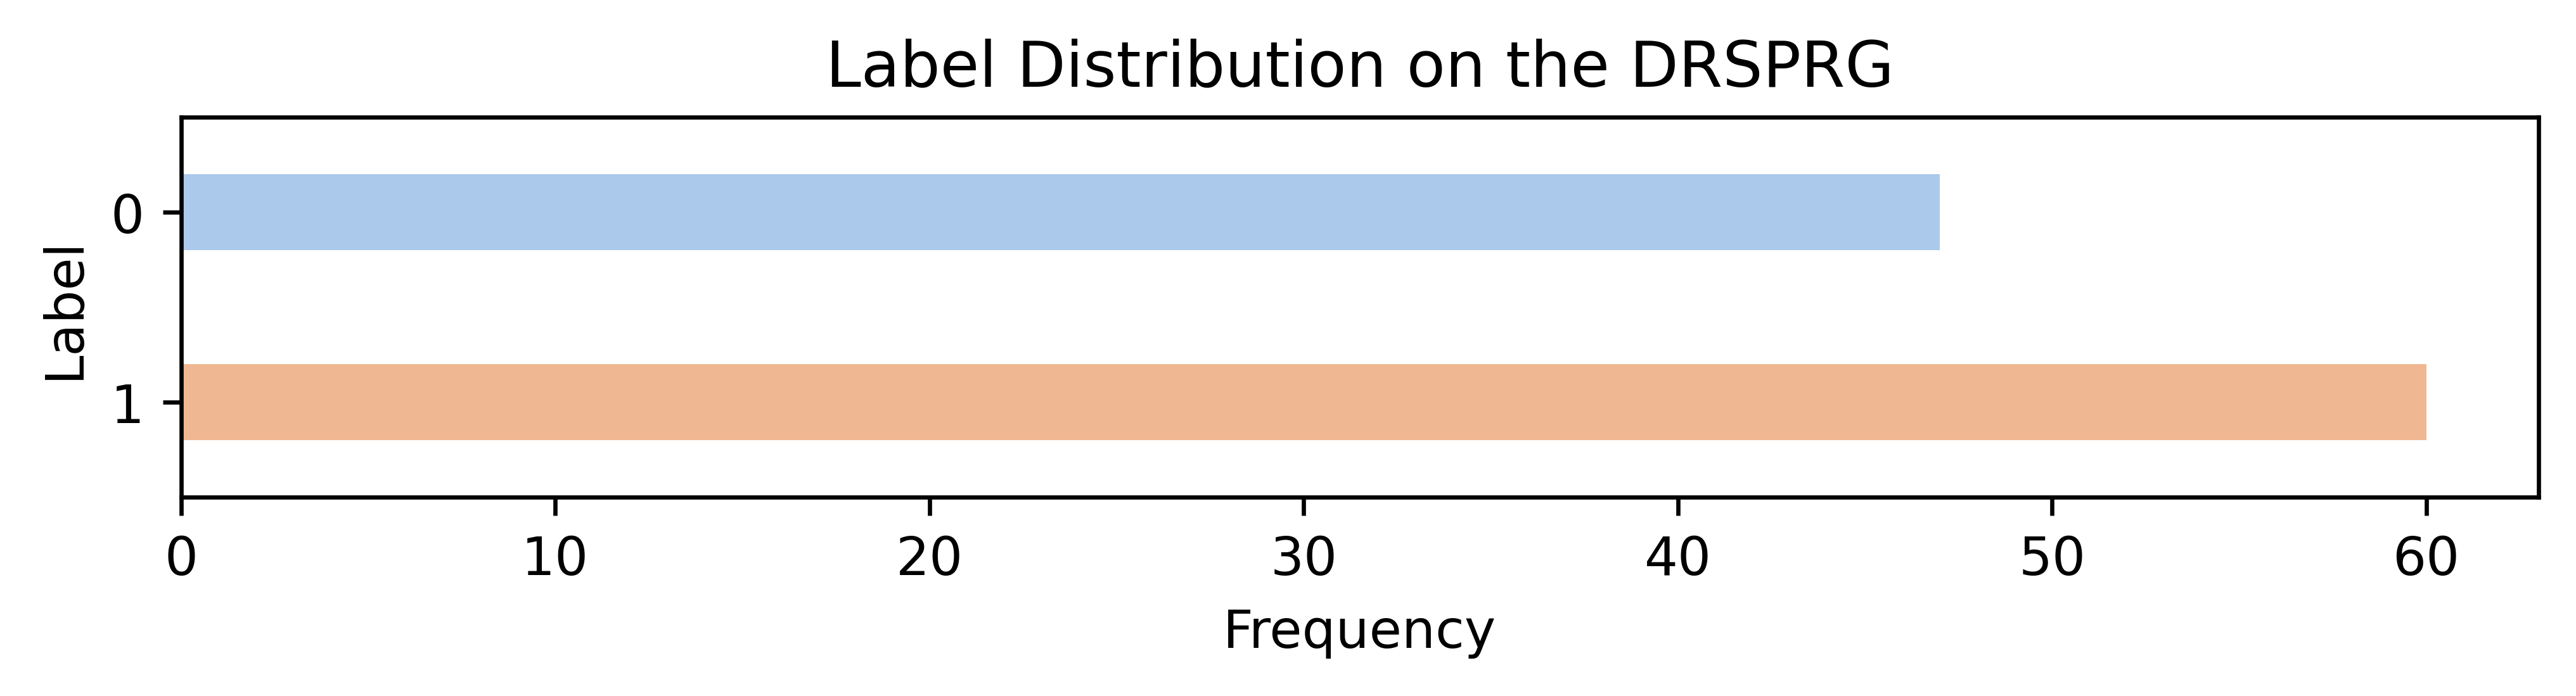

In [68]:
plt.figure(figsize=(8, 2), dpi=600)
sns.countplot(data=df, y="label", hue="label", width=0.4, palette="pastel", legend=False)
plt.title(f"Label Distribution on the {DATASET_NAME.upper()}")
plt.ylabel("Label")
plt.xlabel("Frequency")
plt.gcf().subplots_adjust(top=0.80)
plt.gcf().subplots_adjust(bottom=0.30)
plt.savefig(f"../images/{DATASET_NAME.lower()}_label_dist.pdf")
plt.show()

## Grouping scintigraphy images